<a href="https://colab.research.google.com/github/Emmanuel461/Pre_entrenamiento_RAC/blob/main/Ejemplo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


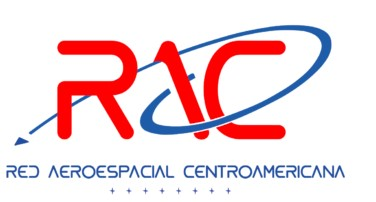

**Sesión 2**: pre-entrenamiento al curso de Radar de Apertura Sintética

**Red Aeroespacial Centroaméricana**


**Compilado por el equipo RAC en noviembre de 2022:**

Jesús Cespedes Rivera jesusc461@gmail.com

María José Molina Montero maria.molinamontero1@gmail.com

Cristian Aguilar-Barboza andresaguilarba20@gmail.com



Lo que ya se vio: 

1. Variables en python
2. Cargar librerías (geemap)
3. Visor de capas y geometrías (cargar colecciones)
4. Creación y visualización de índices de vegetación y RGBs. 
5. Timelapse

Pasos/procedimientos del día de hoy: 


1.   Función reduce() en una imagen
2.   Función reduce() en una colección
3.   RGB temporal
4.   Filtros de nubosidad
5.   Gráfico de variación de NDVI en el tiempo




Realizamos el proceso de siempre (cargar librerias e instalar geemap en el entorno. Esto lo hacemos debido a que esta herramienta usa una computadora "virtual" cada vez que nos conectamos a los servidores. 

**Google Colab** es de uso libre, pero con capacidades limitadas que se mencionan a continuación.

 

1.   El entorno de ejecución se reinicirá luego de 10-15 minutos de inactividad o de 12 horas de computación continua.
2.   Cuando el ambiente de ejecución se reinicia, se pierde toda la información cargada/almacenada y la configuración del ambiente.

3. Los recursos son asignados dinámicamente de acuerdo al tipo de trabajo que se está haciendo.

4. En el caso de trabajos que impliquen computaciones a largo plazo, se sugiere la utilización de hardware dispuesto en un clúster computacional.

5. El manejo de las sesiones activas se realiza desde el menú **Entorno de ejecución → Gestionar sesiones**

6. Con el fin de evitar la pérdida de información y respaldar el trabajo realizado cuando el entorno de ejecución se reinicia, se sugiere de igual forma conectar su almacenamiento en Google Drive a Colab.

In [3]:
 !pip install geemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# Importar librerias al entorno
import geemap
import ee

In [6]:
# Iniciar Sesión en GEE (si les da un error incluso pegando el link de autenticación hay que conectar GEE con Google Cloud)
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=4_-qmKS9teFnus33PS6e8sKnP7sdzXZVOBpfiABs5ZA&tc=voGDYRD5r8_GFYk-0NjsJHf1DbxLvW47Eqx94tLCOG0&cc=nCM_GP21QY-wvBHXgTqUwveV8SteUcbK7ZJ_Wk0k7rM

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AfgeXvsDulsIPHIGWB_jSufp3SJ8jDnevbpYo3kC95KC7gCRv0IRqhqPrQU

Successfully saved authorization token.


In [7]:

import geemap.chart as chart

import json
import pandas as pd

# reminder that if you are installing libraries in a Google Colab instance you will be prompted to restart your kernal

try:
    import geemap, ee
    import seaborn as sns
    import matplotlib.pyplot as plt
except ModuleNotFoundError:
    if 'google.colab' in str(get_ipython()):
        print("package not found, installing w/ pip in Google Colab...")
        !pip install geemap seaborn matplotlib
    else:
        print("package not found, installing w/ conda...")
        !conda install mamba -c conda-forge -y
        !mamba install geemap -c conda-forge -y
        !conda install seaborn matplotlib -y
    import geemap, ee
    import seaborn as sns
    import matplotlib.pyplot as plt

In [8]:
#Nota: Acá debemos dibujar un área de interés. Sino en adelante nos fallará el código.

Map = geemap.Map(center=(10, -80), zoom=6)
Map

Map(center=[10, -80], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(To…

# **Parte 1.** La función **reduce()** en GEE. 
 
Un reducer() es un objeto de Earth Engine que representa una forma de agregar datos o calcular una estadística a una imagen o dato interés. Acá veremos una demostración de las reducciones espaciales.

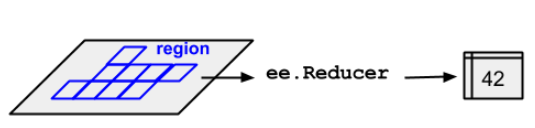

In [9]:
Map.user_roi.getInfo()
# Defina la geometria 
geometry = Map.user_roi

In [10]:
Map.user_roi.getInfo()

{'geodesic': False,
 'type': 'Polygon',
 'coordinates': [[[-86.325073, 11.32656],
   [-86.325073, 11.724856],
   [-85.407715, 11.724856],
   [-85.407715, 11.32656],
   [-86.325073, 11.32656]]]}

In [11]:
Map = geemap.Map(center=(11.472, -85.691), zoom=9)
Map

Map(center=[11.472, -85.691], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chil…

In [12]:
#Asegurarnos de la creación de una geometría / Por si no la crearon en el mapa anterior. 
geometry = ee.Geometry.Polygon([[[-86.022949, 11.22151],
   [-86.022949, 11.739143],
   [-85.358276, 11.739143],
   [-85.358276, 11.22151],
   [-86.022949, 11.22151]]])

dsm = ee.Image("USGS/SRTMGL1_003")

# Obtener la elevación en metros. 
elev = dsm.select('elevation')


# Crear un filtro, dónde filtramos las evelaciones superiores a 100 y las clasificamos en binario (si cumple o no el filtro). 
elevGt100 = elev.gt(100).rename('elevGt100')
# Ver los pixeles que cumplen con el filtro 
elevGt100 = elevGt100.updateMask(elevGt100)
Map.addLayer(elevGt100.clip(geometry), {'palette': ['yellow']}, 'Elevaciones superiores a 100 m')

# Use a static method for a more complex computation.
terrain = ee.Terrain.products(elev)

#Recortamos el DEM y añadirmos la capa de modelo de sombras
Map.addLayer(terrain.clip(geometry), {'bands': ['hillshade']}, 'Modelo de sombras')



**Nota:**

**La importancia de señalar la escala es que si no la especificamos no tenemos claro si se está ejecutando un remuestreo de los valores de píxel, y por tanto lo ideal es trabajar con el valor de entrada de la resolución espacial original de la colección de datos. **

Si se ponen escalas muy bajas (hecho poco común), Earth Engine remuestreará la entrada (vecino más cercano por defecto) a cualquier escala que especifiques. Pero puede llegar exceder tanto el valor adecuado que se da un error. 

In [13]:
# Obtener el valor de elevación promedio para el área de interés 
promedio_elevacion = elev.reduceRegion(
  reducer=ee.Reducer.mean(),
  geometry=geometry,
  scale=30,
  maxPixels=1e9
)

print(promedio_elevacion.get('elevation').getInfo())

63.74720558097407


In [14]:
#Obetener el total área que abarca nuestra área de interés (en m2)

areaelevacion100 = elevGt100 \
    .multiply(ee.Image.pixelArea()) \
    .reduceRegion(
      reducer=ee.Reducer.sum(),
      geometry= geometry,
      scale= 30
    )
print(areaelevacion100.get('elevGt100').getInfo())



582318386.7647312


In [15]:
#Obtener el valor en Ha
area = (582318386.7647312)/10000
print(area)

58231.83867647312


In [17]:
# Obtener el valor de pendiente promedio para el área de interés (OJO AL VALOR DEL scale)
pendiente_promedio = terrain.select('slope').reduceRegion(
   reducer = ee.Reducer.mean(),
   geometry = geometry,
   scale= 1, # Hay que solucionarlo, poner la resolución del DEM 30 m
)

print(pendiente_promedio.get('slope').getInfo())

2.8696293831671817


##**Parte 2. Aplicación de la función reduce() en una colección de imágenes, combinado con la función map () (vista la semana anterior)**##


Anteriormente, se demostró que las reducciones espaciales en las que las entradas al reductor son píxeles en una región espacial, podemos obtener datos estadísticos relevantes de esa área. Sin embargo, si las imágenes de una colección representan observaciones a lo largo del tiempo, la reducción de una ImageCollection es una reducción temporal. En este caso, una pila (conjunto) de píxeles a lo largo del tiempo es la entrada al reductor.  

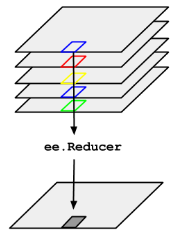

In [20]:
Map = geemap.Map(center=(11.472, -85.691), zoom=9)
Map

Map(center=[11.472, -85.691], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chil…

In [21]:
Map.user_roi.getInfo()

{'geodesic': False,
 'type': 'Polygon',
 'coordinates': [[[-86.21521, 11.334639],
   [-86.21521, 11.699391],
   [-85.385742, 11.699391],
   [-85.385742, 11.334639],
   [-86.21521, 11.334639]]]}

In [22]:
geometry2 = ee.Geometry.Polygon([[[-86.022949, 11.22151],
   [-86.022949, 11.739143],
   [-85.358276, 11.739143],
   [-85.358276, 11.22151],
   [-86.022949, 11.22151]]])

l8sr =  ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filterDate('2022-02-01', '2022-02-18')


# Define a function that will add an NDVI band to a Landsat 8 image.
def addNDVI(image):
  ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI').clip(geometry2)
  return image.addBands(ndvi)

# Map the function over the entire collection.
withNDVI = l8sr.map(addNDVI)


In [23]:
ndviVisParams = {
  'bands': 'NDVI',
  'min': -0.1,
  'max': 0.5,
  'palette': ['white', 'green']
}


In [24]:
Map.addLayer(withNDVI.select('NDVI'), ndviVisParams, 'Landsat 8 con NDVI calculado')

# Obtener la mediana de cada banda, en cada pixel.
median = withNDVI.median().clip(geometry2)
visParams = {'bands': ['SR_B4',  'SR_B3',  'SR_B2'], 'min': 1700, 'max': 17424}
Map.addLayer(median, visParams, 'Mediana de pixel en vista RGB')


# Obtener la mediana del NDVI, en cada pixel
medianNDVI = addNDVI(l8sr.median())
Map.addLayer(medianNDVI, ndviVisParams, 'Mediana del NDVI en el periodo de tiempo')

# Obtener el valor más alto del NDVI, en cada pixel
max = withNDVI.max()
Map.addLayer(max, ndviVisParams, 'Máximo de NDVI en el periodo de tiempo')



**Notas importantes**

La función reducer() se aplica por separado a cada banda y a cada píxel. Las diferentes bandas pueden provenir de momentos diferentes y las bandas de los píxeles adyacentes también pueden provenir de momentos diferentes.  Esto puede estar sesgado por la estacionalidad, la nubosidad, los datos que faltan, etc. **No lo olviden, considerenlo en sus estudios si usan este código.** 

La función de qualityMosaic también se llama un compuesto de píxeles más verdes.  Los píxeles en este compuesto fueron medidos por el sensor.  Son los píxeles del conjutno de imágenes que tienen el NDVI más alto.  Esto podría ser útil para asegurar los píxeles reales, o para controlar la fenología, pero también daría resultados insatisfactorios sobre el agua (zonas de baja reflectancia).

## **Parte 3. Continuamos...**
A continuación mediante la visualización de un RGB, vamos realizar un monitoreo espacio-temporal simple. 

Seleccionamos diferentes fechas y las pasamos por cada uno de los canales de color. 


In [25]:
#Primero añadimos un mapa para visualizar los resultados
Map = geemap.Map(center=(14.470, -90.816), zoom=12)
Map

Map(center=[14.47, -90.816], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(child…

In [26]:
#Debemos dibujar un área de interés en el map anterior, enfoque el área en los sectores de los volcanes
Map.user_roi.getInfo()

{'geodesic': False,
 'type': 'Polygon',
 'coordinates': [[[-90.928688, 14.431355],
   [-90.928688, 14.52543],
   [-90.711365, 14.52543],
   [-90.711365, 14.431355],
   [-90.928688, 14.431355]]]}

In [27]:
#Definimos la geometría, si quiere que sea exacta copie y pegue las coordenadas de la línea de código anterior
geometry3 = ee.Geometry.Polygon([[[-90.986023, 14.368173],
   [-90.986023, 14.561965],
   [-90.602875, 14.561965],
   [-90.602875, 14.368173],
   [-90.986023, 14.368173]]])

In [28]:
#Llamado de las imágenes de Landsat 8
l8 =  ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")


# Definimos una función para calcular el NDVI a todas las imágenes dentro de la colección de L8. 
def addNDVI(image):
  ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI').clip(geometry3)
  return image.addBands(ndvi)

# Aplicar la función a la colección completa. 
withNDVI2 = l8.map(addNDVI)


In [29]:
#Vamos a crear un RGB por donde vamos a pasar por cada color una fecha diferente. 
#Las siguientes líneas lo que definen son variables donde cada variable es una imagen promedio de un conjunto de imágenes en un rango de fechas. 

Fecha1 = withNDVI2.filterDate('2018-03-01', '2018-03-30').select('NDVI').mean().rename('2018-03').clip(geometry3)
Fecha2 = withNDVI2.filterDate('2018-11-01', '2018-11-30').select('NDVI').mean().rename('2018-11').clip(geometry3)
Fecha3 = withNDVI2.filterDate('2019-03-01', '2019-03-17').select('NDVI').mean().rename('2019-03').clip(geometry3)

# Unir las imágenes en un solo archivo (apilado). Se deben colocar en órden de menos a más reciente
join = Fecha1.addBands(Fecha2).addBands(Fecha3)

#Añadir la imagen a la vista
Map.addLayer(join, {'min':0, 'max':0.65}, 'RGB')


In [30]:
#Cargar para las fechas seleccionadas del NDVI su correspondiente RGB para validar lo mostrado. 

#Ajustes de visualización
visParams = {'bands': ['SR_B4',  'SR_B3',  'SR_B2'], 'min': 4200, 'max': 28000}

# Selección de fechas y recorte para el área de interés. 
ejemplo1 = l8.filterDate('2018-03-01', '2018-03-30').mean().clip(geometry3)
ejemplo2 = l8.filterDate('2018-11-01', '2018-11-30').mean().clip(geometry3)
ejemplo3 = l8.filterDate('2019-03-01', '2019-03-17').mean().clip(geometry3)

#Cargar las capas. 
Map.addLayer(ejemplo1, visParams, '2018-03')
Map.addLayer(ejemplo2, visParams, '2018-11')
Map.addLayer(ejemplo3, visParams, '2019-01')

# **Parte 4. Filtrado de nubosidad y graficado de NDVI en el tiempo**

Acá lo que se hará es aplicar un filtro de nubosidad en la colección de imágenes, luego calcularemos el NDVI y veremos su variación en el tiempo para un área de interés. 

In [31]:
#Primero añadimos un mapa para visualizar los resultados
Map = geemap.Map(center=(14.470, -90.816), zoom=12)
Map

Map(center=[14.47, -90.816], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(child…

In [32]:
l8raw =  ee.ImageCollection("LANDSAT/LC08/C01/T1").filterDate('2020-03-01', '2020-03-30')

# Method 1
# This demonstrates use of ee.Algorithms.Landsat.simpleComposite().
# Note that ee.Algorithms.Landsat.simpleCloudScore() is used to sort
# pixels, with a median reducer applied to the least cloudy pixels.
# Note that raw data is needed for input.
composite = ee.Algorithms.Landsat.simpleComposite(l8raw)


#Map.addLayer(l8raw)
# Display
visParams = {'bands': ['B4',  'B3',  'B2'], 'min': 0, 'max': 45}
Map.addLayer(composite.clip(geometry3), visParams, 'simpleComposite')


In [33]:
# Method 2
# This example demonstrates the use of the pixel QA band to mask
# clouds in Landsat 8 surface reflectance (SR) data.


L8sr = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")


# Function to cloud mask from the pixel_qa band of Landsat 8 SR data.
def maskL8sr(image):
  # Bits 3 and 5 are cloud shadow and cloud, respectively.
  cloudShadowBitMask = 1 << 3
  cloudsBitMask = 1 << 5

  # Get the pixel QA band.
  qa = image.select('QA_PIXEL')

  # Both flags should be set to zero, indicating clear conditions.
  mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
      .And(qa.bitwiseAnd(cloudsBitMask).eq(0))

  # Return the masked image.
  return image.updateMask(mask)

# Map the function over the collection and reduce using the median.
composite = l8sr.map(maskL8sr).median().divide(10000)

visParams2 = {'bands': ['SR_B4',  'SR_B3',  'SR_B2'], 'min': 0.3, 'max': 2}

# Display the results.
Map.addLayer(composite.clip(geometry3), visParams2, 'composite m2')

# **Gráfico de NDVI**

In [34]:
# Vamos a crear un punto, ya casi vemos el sitio, y vamos a crear un buffer con relación a ese punto. 
geometry_point = ee.Geometry.Point([-90.879936, 14.474242]).buffer(100)

In [35]:
# Definir una función que añada una banda NDVI a a cada imagen Landsat 8 dentro de la colección. 
def addNDVI(image):
  ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
  return image.addBands(ndvi)

# Filtrar y asignar la función sobre la colección. // OJO con la función filterBounds()
withNDVI = L8sr.filterDate('2018-01-01', '2018-12-31').map(addNDVI).filterBounds(geometry_point)

In [36]:
# Creamos una función para obtener el promedio del valor del NDVI en el buffer del punto que creamos anteriormente 
# y que nos devuelva el promedio y la fecha
def poi_mean(img):
    mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=geometry_point, scale=30).get('NDVI')
    return img.set('date', img.date().format()).set('mean',mean)

In [37]:
#Aplicamos la función creada anteriormente a la colección del NDVI, para obtener el promedio para el punto de interés (con buffer) para cada imágen. 
poi_reduced_imgs = withNDVI.map(poi_mean)

**Para convertir a un dataframe con pandas, no queremos una ImageCollection; entonces , vamos a reducir nuestras imágenes a una lista:**

Para cada imagen, tenemos una lista de 2 elementos que contiene la fecha de esa imagen y el valor medio (para nuestro punto de interés con buffer)

Cada una de estas listas son a su vez elementos de nuestra lista final, que es la que convertiremos en un dataframe.

In [38]:
nested_list = poi_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['date','mean']).values().get(0)

In [39]:
import json
import pandas as pd

# Vamos a crear una tabla de datos con los datos de Id (por defecto), fecha y promedio, usamos la librería de pandas para manejar este tipo de datos. 
df = pd.DataFrame(nested_list.getInfo(), columns=['date','mean'])

df

,date,mean
0,2018-01-16T16:24:09,0.026553
1,2018-02-01T16:23:59,0.051571
2,2018-02-17T16:23:54,0.025867
3,2018-03-05T16:23:47,0.017242
4,2018-03-21T16:23:38,0.013255
5,2018-04-06T16:23:31,0.044269
6,2018-04-22T16:23:21,0.024274
7,2018-05-08T16:23:12,0.038008
8,2018-05-24T16:23:00,0.036687
9,2018-06-09T16:22:56,0.101284


In [40]:
#Vamos a ajustar la fecha de modo que pueda ser leída de forma correcta por el gráfico. 

df['date'] = pd.to_datetime(df['date'])

df = df.set_index('date')

df

,mean
date,
2018-01-16 16:24:09,0.026553
2018-02-01 16:23:59,0.051571
2018-02-17 16:23:54,0.025867
2018-03-05 16:23:47,0.017242
2018-03-21 16:23:38,0.013255
2018-04-06 16:23:31,0.044269
2018-04-22 16:23:21,0.024274
2018-05-08 16:23:12,0.038008
2018-05-24 16:23:00,0.036687


In [41]:
#Vamos a crear una serie temporal, pero primero vamos a ver dónde estamos analizando.

volcanMap = geemap.Map()
volcanMap.centerObject(geometry_point, zoom=13)
volcanMap.add_basemap("SATELLITE")
volcanMap.addLayer(geometry_point, {}, "Volcán de Fuego")
volcanMap.addLayerControl()
volcanMap

Map(center=[14.474242102571434, -90.87993599703988], controls=(WidgetControl(options=['position', 'transparent…

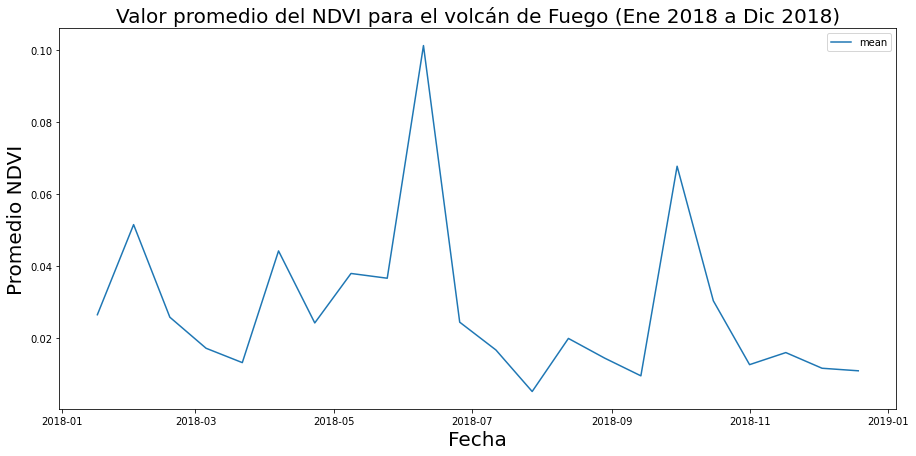

In [42]:
# Creamos una figura con pyplot y establecemos las dimensiones a 15 x 7
fig, ax = plt.subplots(figsize=(15,7))

# Crear el gráfico estableciendo nuestro marco de datos en el argumento de los datos
sns.lineplot(data=df, ax=ax)

# Preparar el título del gráfico y de los ejes
ax.set_ylabel('Promedio NDVI',fontsize=20)
ax.set_xlabel('Fecha',fontsize=20)
ax.set_title('Valor promedio del NDVI para el volcán de Fuego (Ene 2018 a Dic 2018)',fontsize=20);

**Hasta acá el ejercicio.**

Para dudas o consultas comunicarse con el equipo RAC. (O contactos al inicio del código). 

Muchas gracias. 

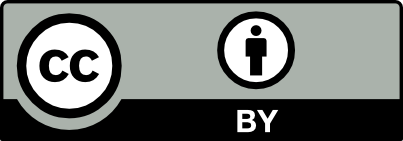